In [101]:
DATA_PATH = "../data/preprocessed/engineering/marketing_campaign.csv" 

In [102]:
import pandas as pd
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from sklearn.preprocessing import StandardScaler, MinMaxScaler


# set the max columns to none
pd.set_option('display.max_columns', None)

In [103]:
df = pd.read_parquet(DATA_PATH)
df.head()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Customer_Tenure,total_Spent,total_purchases,Children,Income_per_Person,Campaign_Participation,Recency_Category,total_spent_per_time,total_purchases_per_time
0,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,1.386294,2.197225,2.397895,1.609438,2.079442,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,0,0,0,0,0,0,1,57,663,31.378848,6.204558,0,29069.0,1,Recent,0.047329,0.009358
1,2.484907,0.693147,1.945910,1.098612,0.693147,1.945910,1.098612,0.693147,0.693147,1.098612,1.791759,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,0,0,0,0,0,0,0,60,113,8.861634,2.484907,2,11586.0,0,Recent,0.078422,0.021990
2,6.056784,3.912023,4.852030,4.718499,3.091042,3.761200,0.693147,2.197225,1.098612,2.397895,1.609438,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,0,0,0,0,0,0,0,49,312,26.391579,5.693732,0,35806.5,0,Very Recent,0.084588,0.018249
3,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,1.098612,1.098612,0.000000,1.609438,1.945910,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,0,0,0,0,0,0,0,30,139,12.714816,2.708050,1,8882.0,0,Very Recent,0.091473,0.019482
4,5.159055,3.784190,4.779123,3.850148,3.332205,2.772589,1.791759,1.791759,1.386294,1.945910,1.791759,1981,PhD,Married,58293.0,1,0,2014-01-19,94,0,0,0,0,0,0,0,33,161,23.677309,5.123964,1,19431.0,0,Long Time,0.147064,0.031826


In [104]:
df.dtypes.value_counts()

float64           17
int64             15
object             2
datetime64[ns]     1
category           1
Name: count, dtype: int64

In [105]:
df.columns

Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Customer_Tenure',
       'total_Spent', 'total_purchases', 'Children', 'Income_per_Person',
       'Campaign_Participation', 'Recency_Category', 'total_spent_per_time',
       'total_purchases_per_time'],
      dtype='object')

### Q1 : Who are the company's ideal customers?

In [106]:
# an ideal customer might have high engagement, high spending, frequent purchases, or high responsiveness to promotions.



# Define high spenders: customers who are in the top 20% of total spending
# high spent on long time or good spent on short time
high_spend_threshold1 = df['total_Spent'].quantile(0.80)
high_spend_threshold2 = df['total_spent_per_time'].quantile(0.80)

high_Spenders = ((df['total_Spent'] > high_spend_threshold1)  | (df['total_spent_per_time'] > high_spend_threshold2)) # .astype(int)


# Define high engagement: customers who have a high number of purchases and accepted multiple campaigns
high_purchases_threshold1 = df['total_purchases'].quantile(0.80)
high_purchases_threshold1 = df['total_purchases_per_time'].quantile(0.80)

high_purchases = ((df['total_purchases'] > high_purchases_threshold1)  | (df['total_purchases_per_time'] > high_purchases_threshold1)) # .astype(int)

# high campaigns participate
high_participation = (df['Campaign_Participation'] >= 1)

high_engagement = (high_purchases & high_participation)
                  

df['High_Value_Customer'] = (high_engagement & high_Spenders ).astype(int)

df['High_Value_Customer'].value_counts()


High_Value_Customer
0    1765
1     258
Name: count, dtype: int64

In [107]:
ideal_customers = df[df['High_Value_Customer'] == 1]
ideal_customers.shape

(258, 37)

In [108]:
ideal_customers.columns

Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Customer_Tenure',
       'total_Spent', 'total_purchases', 'Children', 'Income_per_Person',
       'Campaign_Participation', 'Recency_Category', 'total_spent_per_time',
       'total_purchases_per_time', 'High_Value_Customer'],
      dtype='object')

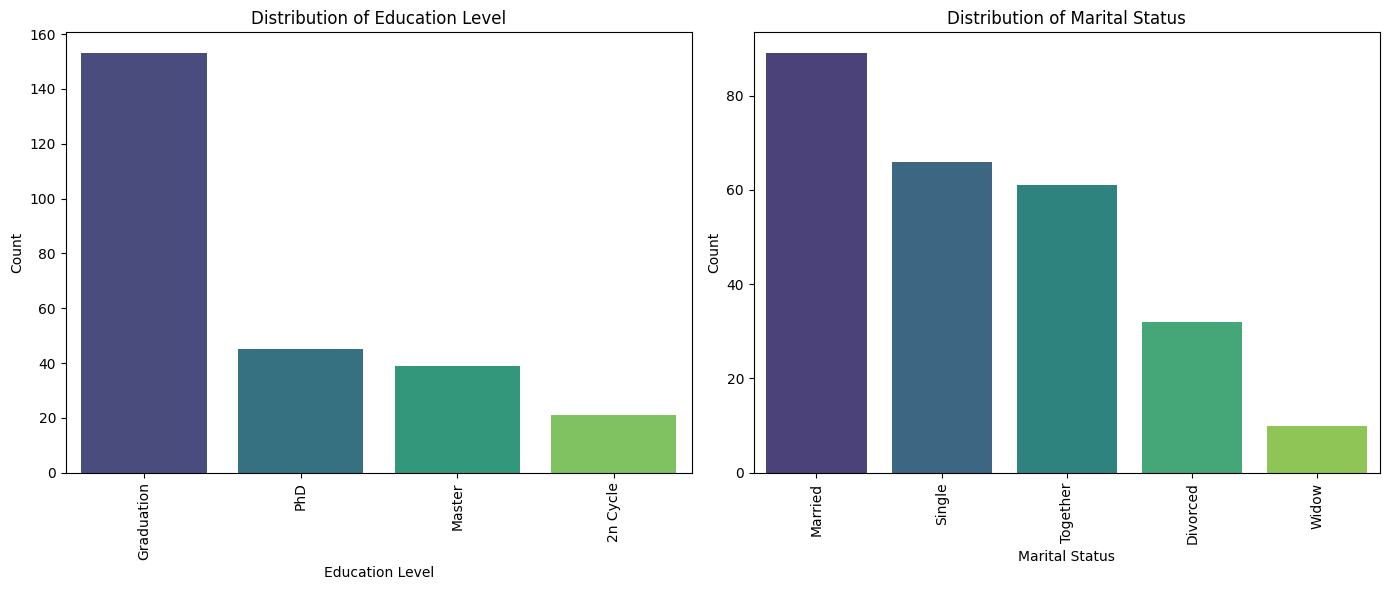

In [109]:
# Summary statistics of ideal customers
ideal_customers_summary = ideal_customers.describe()

# Distribution of ideal customers' education level and marital status
education_counts = ideal_customers['Education'].value_counts()
marital_status_counts = ideal_customers['Marital_Status'].value_counts()

# Create a figure with two subplots stacked vertically
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the distribution of Education levels with vertical bars
sns.barplot(x=education_counts.index, y=education_counts.values, ax=ax[0], palette="viridis")
ax[0].set_title("Distribution of Education Level")
ax[0].set_xlabel("Education Level")
ax[0].set_ylabel("Count")
ax[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Plot the distribution of Marital Statuses with vertical bars
sns.barplot(x=marital_status_counts.index, y=marital_status_counts.values, ax=ax[1], palette="viridis")
ax[1].set_title("Distribution of Marital Status")
ax[1].set_xlabel("Marital Status")
ax[1].set_ylabel("Count")
ax[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

/home/tarek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


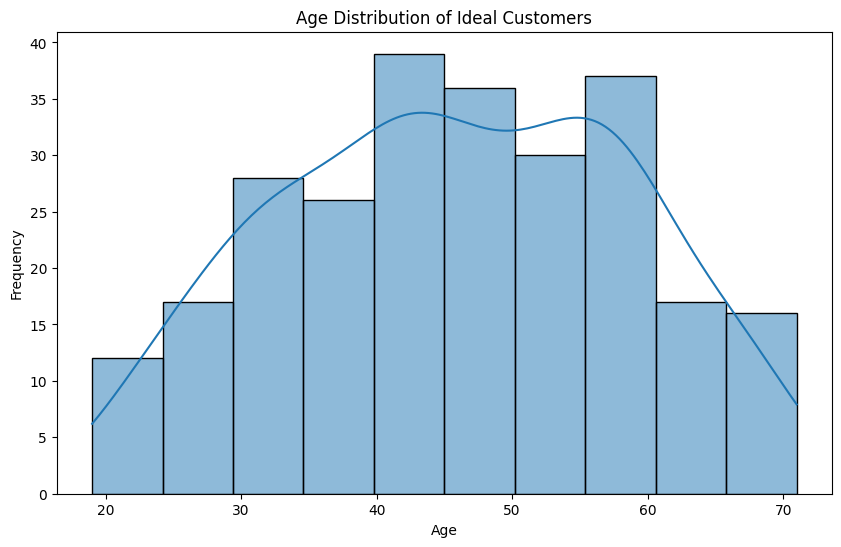

/home/tarek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


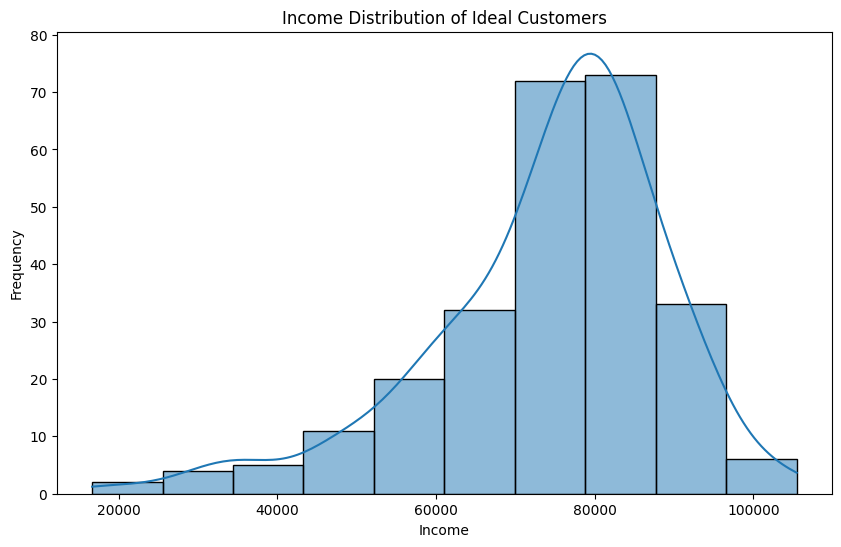

In [110]:
# Age distribution of ideal customers
plt.figure(figsize=(10, 6))
sns.histplot(ideal_customers['Age'], bins=10, kde=True)
plt.title('Age Distribution of Ideal Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Income distribution of ideal customers
plt.figure(figsize=(10, 6))
sns.histplot(ideal_customers['Income'], bins=10, kde=True)
plt.title('Income Distribution of Ideal Customers')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()


In [114]:
ideal_customer_profile = {
    'average_age': ideal_customers['Age'].mean(),
    'average_income': ideal_customers['Income'].mean(),
    'top_education_levels': education_counts.idxmax(),
    'top_marital_status': marital_status_counts.idxmax(),
    'average_total_spending': ideal_customers['total_Spent'].mean(),
    'average_num_web_purchases': ideal_customers['NumWebPurchases'].mean(),
    'average_num_store_purchases': ideal_customers['NumStorePurchases'].mean(),
    'average_num_catalog_purchases': ideal_customers['NumCatalogPurchases'].mean(),
    'average_Campaign_Participation': ideal_customers['Campaign_Participation'].mean()
}

print("Ideal Customer Profile:")
print(ideal_customer_profile)


Ideal Customer Profile:
{'average_age': 45.85271317829457, 'average_income': 74146.82945736434, 'top_education_levels': 'Graduation', 'top_marital_status': 'Married', 'average_total_spending': 27.10218410617494, 'average_num_web_purchases': 1.788707448668131, 'average_num_store_purchases': 2.099481988528228, 'average_num_catalog_purchases': 1.7664757186309892, 'average_Campaign_Participation': 1.806201550387597}
